# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.signal as scp
from pylab import *

In [4]:
def calculate_ti(W0, theta, tj, sigma, c, wavelength):
    numerator = theta - math.acos((W0 - tj) / sigma)
    denominator = (2 * math.pi * c**2) / wavelength
    ti = wavelength * (numerator / denominator)
    return ti
# ti = calculate_ti(30,1,30,1,1,1)
# print(ti)
ti = np.arange(29, 31, 0.1)
ti2 = [calculate_ti(30, 1, t, 1, 1, 1) for t in ti]
print(ti2)

[0.15915494309189535, 0.08737179652754168, 0.05673856074232785, 0.03256328753857691, 0.011571325441460938, -0.007511723574772621, -0.025350116690878825, -0.04235171489776719, -0.05879794848361905, -0.07490291669347675, -0.09084505690810692, -0.10678719712273713, -0.1228921653325949, -0.1393383989184469, -0.15633999712533544, -0.17417839024144194, -0.1932614392576759, -0.2142534013547926, -0.23842867455854475, -0.26906191034376137]


# Functions

In [5]:
def gaussian_noise(p,mu,std):
    # p is the pulse
    # mu is the mean
    # std is the standard deviation
    noise = np.random.normal(mu, std, size = p.shape)
    noisy_p = p + noise
    return noisy_p 

def derive_filter(signal, filter_coeffs):
    # Apply the filter using the 'lfilter' function
    filtered_signal = scp.lfilter(filter_coeffs, 1.0, signal)
    return filtered_signal

def find_zero_crossings(t, signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return t[zero_crossings]


# FIR filter functions (planned for solution b if solution a won't work)

def freqph(b,a=1): # Plot frequency and phase response 
    w,h = scp.freqz(b, a=1, worN=512, whole=False, plot=None, fs=64, include_nyquist=False) # Compute the frequency response of a digital filter
    h_dB = 20 * log10 (abs(h))
    fig, axes = plt.subplots(1,1, figsize=(22, 15))  # Create a 4x4 grid of subplots
    subplot(211) #2 rows, 1 column, the first plot.
    plot(w/max(w),h_dB)
    ylim(-150, 5)
    ylabel('Magnitude (db)')
    xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    title(r'Frequency response')
    subplot(212) #2 rows, 1 column, the second plot.
    h_Phase = unwrap(arctan2(imag(h),real(h)))
    plot(w/max(w),h_Phase)
    ylabel('Phase (radians)')
    xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    title(r'Phase response')
    subplots_adjust(hspace=0.5)

def implz(b,a=1): # Plot step and impulse response
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = scp.lfilter(b,a,impulse) #Filter data along one-dimension with a FIR filter.
    fig, axes = plt.subplots(1,1, figsize=(22, 15))  # Create a 4x4 grid of subplots
    subplot(211) #2 rows, 1 column, the first plot.
    stem(x, response)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Impulse response')
    subplot(212) #2 rows, 1 column, the second plot.
    step = cumsum(response) #Return the cumulative sum
    stem(x, step)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Step response')
    subplots_adjust(hspace=0.5) #Adjust the subplot layout parameters.

def make_pulse(duration = 1, amplitude = 1 , fs = 64):
    # duration in ns
    # fs in GHz
    ts = 1/fs # ns

    sample_count = int(duration/ts)
    timestep = [ts * i for i in range(sample_count)]

    # A and B Values are ajusted to the double exponential last around 1ns with a quick rising time 
    A = 11
    B = 10

    tmax = math.log(B/A)/(B-A)
    current_max = math.exp(-A*tmax)-math.exp(-B*tmax)
    C = amplitude/current_max

    samples = []
    for i in range(sample_count):
        samples.append(C*(math.exp(-A*timestep[i])-math.exp(-B*timestep[i])))

    samples = np.asarray(samples)
    time = np.asarray(timestep)

    samples = samples/samples.max() # normalize

    samples[samples<(amplitude/1000)] = 0   # force last value to zero

    shift = np.unravel_index(np.argmax(samples), samples.shape)[0]

    #noisy_samples= gaussian_noise(samples,0.0,0.1) # add Gaussian noise

    fig, axes = plt.subplots(1,1, figsize=(22, 15))  # Create a 4x4 grid of subplots
    axes.plot(time, samples)
    axes.set_xlabel('Time (ns)')
    axes.set_ylabel('Amplitude')
    plt.show()

    # apply FIR filter
    n = 61
    #This function computes the coefficients of a finite impulse response filter. The filter will have linear phase
    # It will be Type I if numtaps is odd and Type II if numtaps is even.
    # Type II filters always have zero response at the Nyquist frequency, so a ValueError exception is raised if firwin is called with numtaps even and having a passband whose right end is at the Nyquist frequency.
    #a= scp.firwin(n, cutoff =0.3 , window = "hamming", fs=64) #FIR filter design using the window method
    #a= scp.firwin(n, cutoff =0.3 , window = "gaussian", fs=64)
    #a= scp.firwin(n, cutoff =0.3 , window = "blackman", fs=64)
    #a = scp.firwin(n, cutoff =30.0 , window=('kaiser', 8), pass_zero='lowpass', scale=True, nyq=None, fs=64)
    #a = scp.firwin(n, cutoff =0.3 , window ='exponential')

    #freqph(a)
    #show()
    #implz(a)
    #show()  

    # apply derivator
    # apply zero-crossing

    return time, samples, shift

def hits2pulses(x):
    fs = 64  # GHz
    ts = 1 / fs
    duration = 1000
    time, samples, shift = make_pulse()

    pulses = np.zeros((x.shape[0], x.shape[1], fs * duration))

    for shot in range(x.shape[0]):
        for chan in range(x.shape[1]):
            hits = x[shot, chan]
            hits = hits[hits > 0]

            hits_norm = hits/127

            hits_norm_q = (hits_norm * fs).astype(int) / fs

            hits_norm_q_scale = hits_norm_q * duration
            time = np.arange(0, duration, ts)
            ind_list = np.zeros_like(hits_norm_q_scale)

            for i in range(hits_norm_q_scale.shape[0]):
                ind_list[i] = hits_norm_q_scale[i] / ts

            signal = np.zeros_like(time)
            ind_list = np.ndarray.astype(ind_list, int)

            for i in range(ind_list.shape[0]):
                start = ind_list[i] - shift
                stop = ind_list[i] + samples.shape[0] - shift
                if stop - start <= samples.shape[0]:
                    if start >= 0 and stop <= signal.shape[0]:
                        signal[start:stop] = samples[:stop - start]

            pulses[shot, chan, :] = signal
    return time, pulses

# Running the code

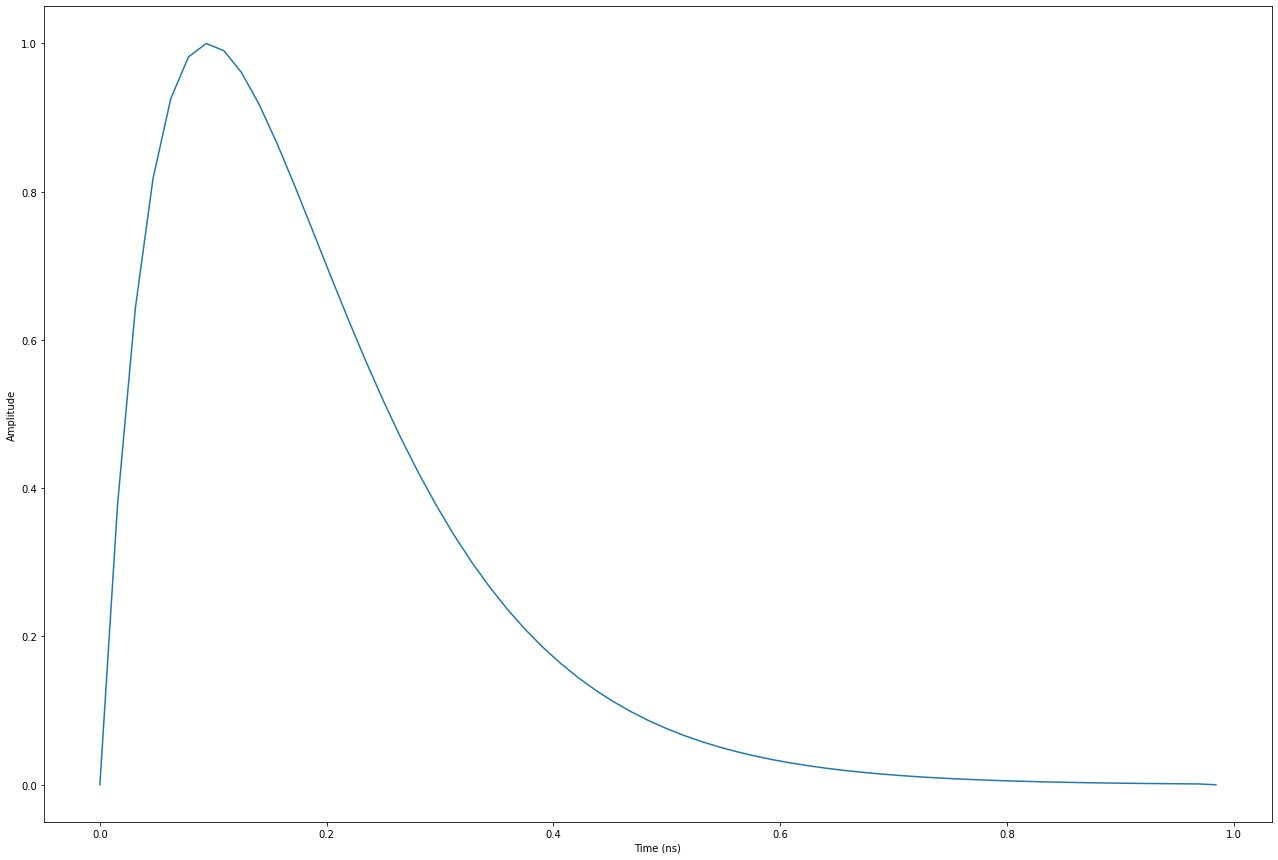

[0.00000000e+00 1.56250000e-02 3.12500000e-02 ... 9.99953125e+02
 9.99968750e+02 9.99984375e+02]
[29.  29.1 29.2 29.3 29.4 29.5 29.6 29.7 29.8 29.9 30.  30.1 30.2 30.3
 30.4 30.5 30.6 30.7 30.8 30.9]


In [6]:
# x_train = np.load("./dataset/trainSet.npz")['x_train']
x_test = np.load("./dataset/testSet.npz")['x_test']

# y_train = np.load("./dataset/trainSet.npz")['y_train']
y_test = np.load("./dataset/testSet.npz")['y_test']

# pulses_train = hits2pulses(x_train)
time, pulses_test = hits2pulses(x_test)
print(time)
print(ti)

# TODO compare time to ti (calculate_ti)
# print(np.square(time - ti).sum())

# saving
# np.savez("./dataset/pulses_trainSet.npz", x_train=pulses_train, y_train=y_train)
np.savez("./dataset/pulses_testSet.npz", x_test=pulses_test, y_test=y_test)

[ 2.75800730e-04 -7.55284175e-05 -8.17589500e-04  4.30822292e-04
  1.66606330e-03 -1.31505191e-03 -2.77004279e-03  3.05122260e-03
  3.94499771e-03 -6.00708699e-03 -4.83350294e-03  1.05755691e-02
  4.86503752e-03 -1.71926533e-02 -3.18107905e-03  2.64700577e-02
 -1.59401111e-03 -3.96757071e-02  1.21981996e-02  6.05748010e-02
 -3.67219488e-02 -1.06070475e-01  1.25086197e-01  4.71115908e-01
  4.71115908e-01  1.25086197e-01 -1.06070475e-01 -3.67219488e-02
  6.05748010e-02  1.21981996e-02 -3.96757071e-02 -1.59401111e-03
  2.64700577e-02 -3.18107905e-03 -1.71926533e-02  4.86503752e-03
  1.05755691e-02 -4.83350294e-03 -6.00708699e-03  3.94499771e-03
  3.05122260e-03 -2.77004279e-03 -1.31505191e-03  1.66606330e-03
  4.30822292e-04 -8.17589500e-04 -7.55284175e-05  2.75800730e-04]
we need them for FIR/FPGA implementation(DSP)


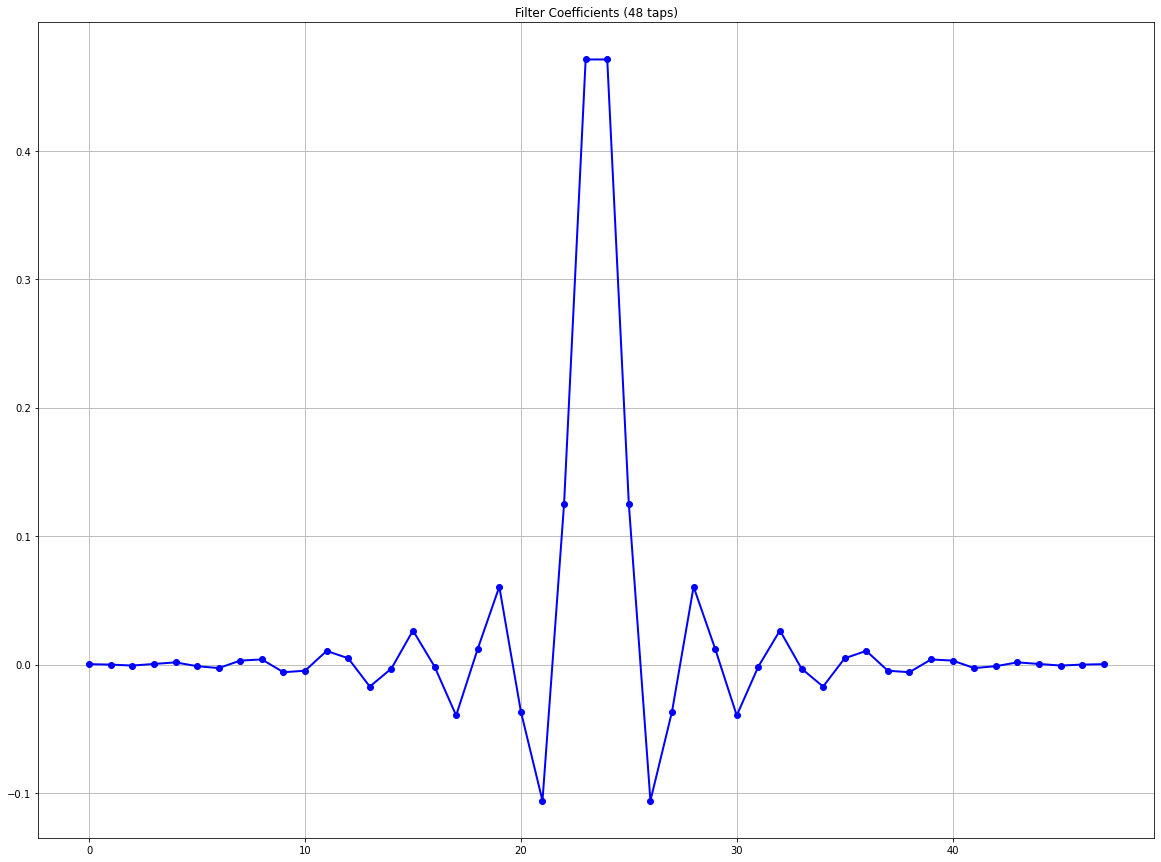

<Figure size 432x288 with 0 Axes>

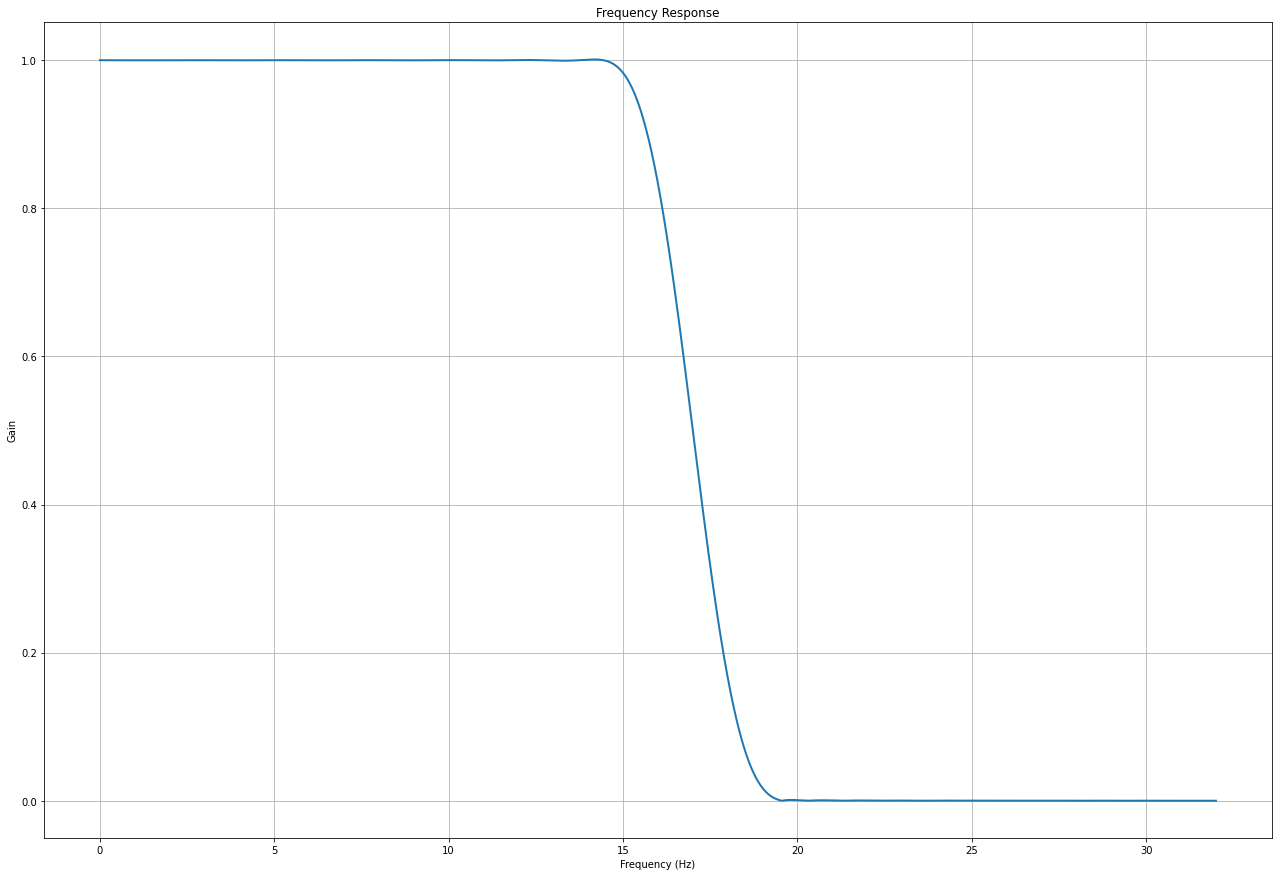

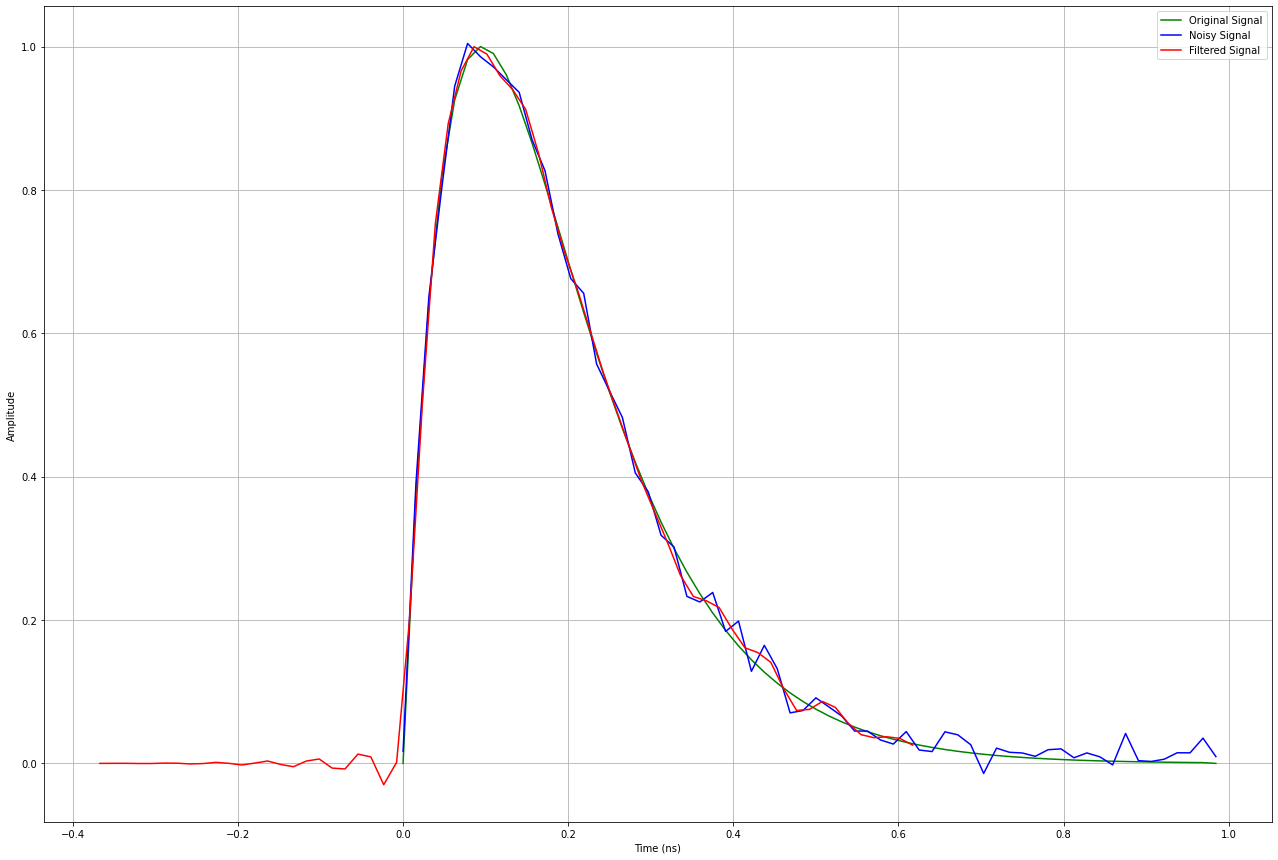

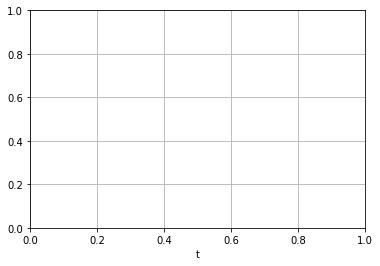

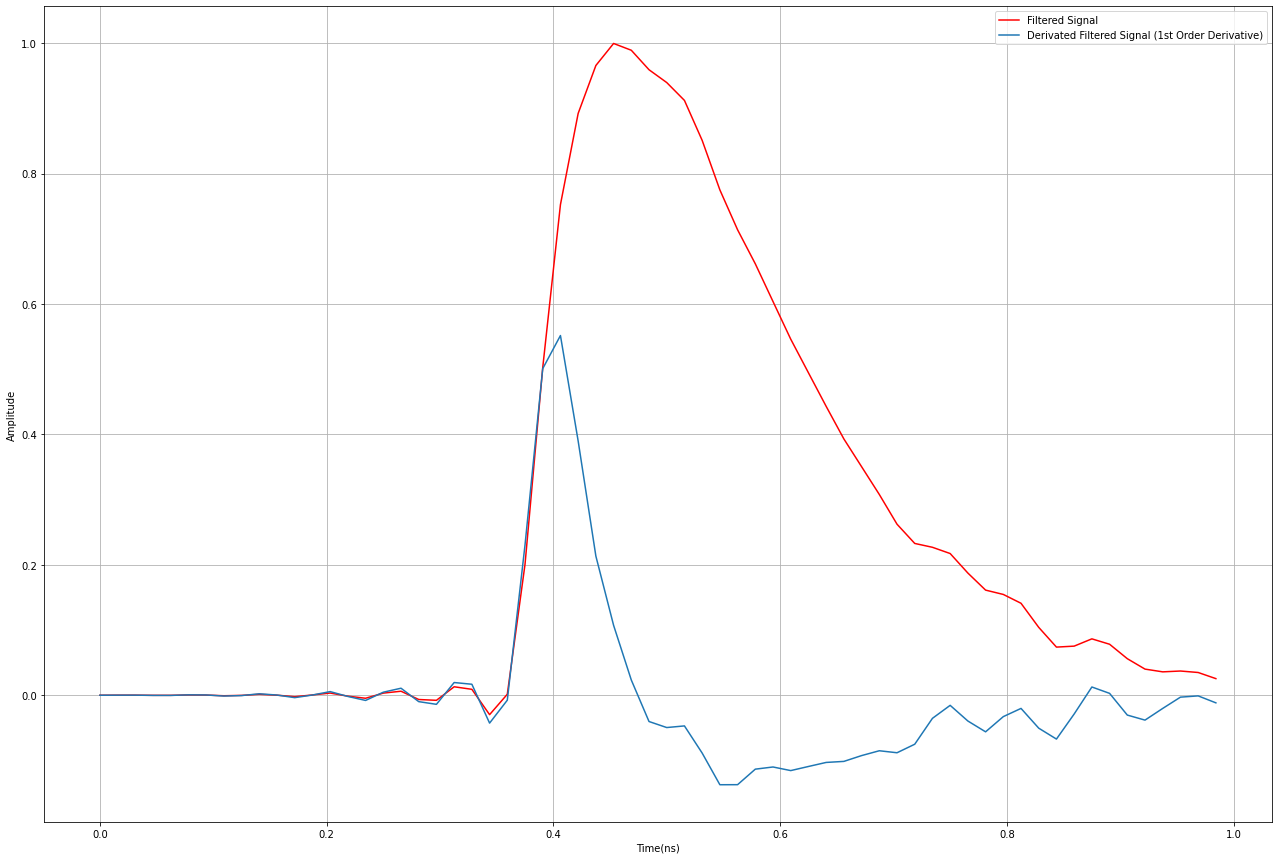

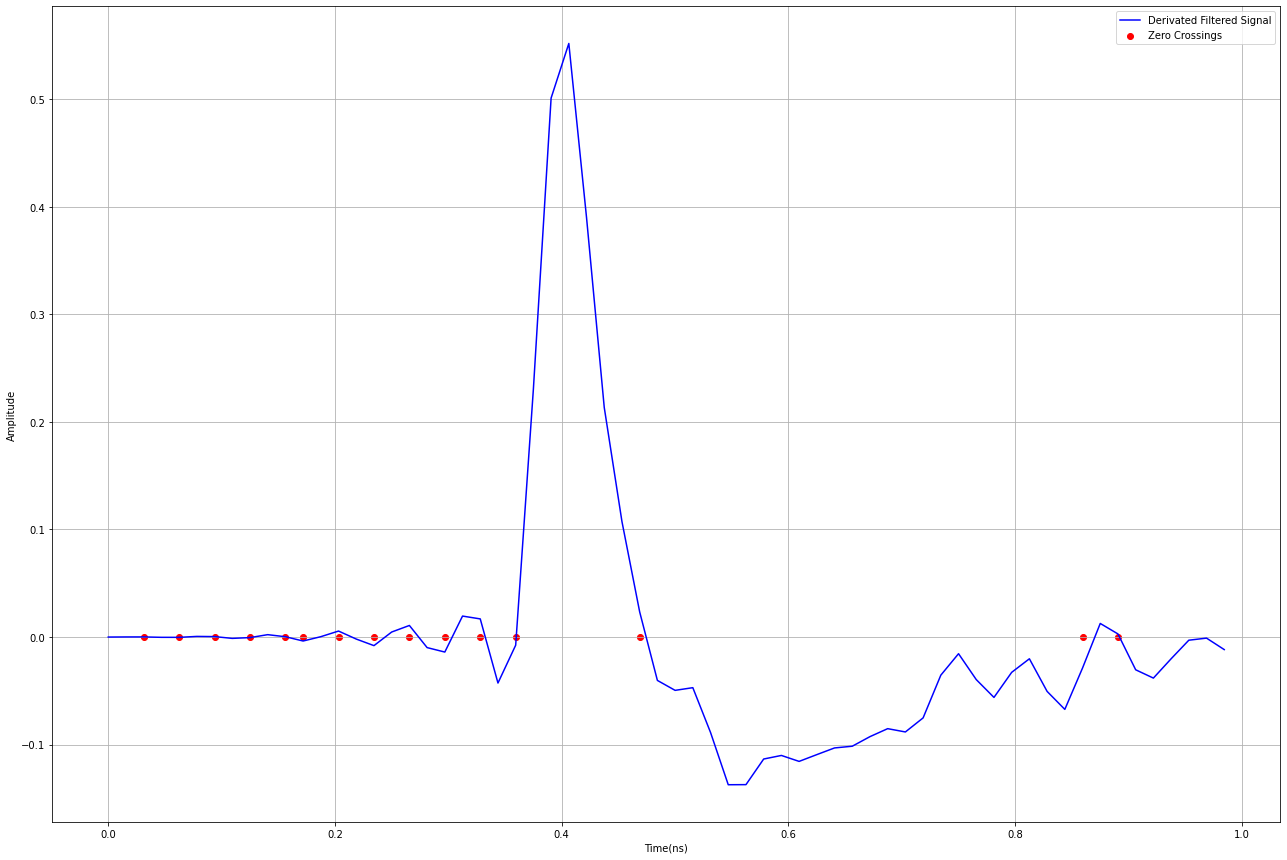

In [10]:
fs = 64.0 
ts = 1 / fs
amplitude = 1
duration = 1
sample_count = int(duration/ts)
timestep = [ts * i for i in range(sample_count)]

# A and B Values are ajusted to the double exponential last around 1ns with a quick rising time 
A = 11
B = 10

tmax = math.log(B/A)/(B-A)
current_max = math.exp(-A*tmax)-math.exp(-B*tmax)
C = amplitude/current_max

x = []
for i in range(sample_count):
    x.append(C*(math.exp(-A*timestep[i])-math.exp(-B*timestep[i])))
x = np.asarray(x)
t = np.asarray(timestep)
x = x/x.max() # normalize
x[x<(amplitude/1000)] = 0

# Create a FIR filter and apply it to x:

xg= gaussian_noise(x,0.0,0.02)

# The Nyquist rate of the signal.
nyq_rate = fs / 2.0

# The desired width of the transition from pass to stop, relative to the Nyquist rate.  We'll design the filter with a 5 Hz transition width.
width = 5/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = scp.kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 17.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = scp.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
# Use lfilter to filter x with the FIR filter.
filtered_x = scp.lfilter(taps, 1.0, xg) 

# Plot the FIR filter coefficients.
fig, axs = plt.subplots(1,1, figsize=(20, 15))
figure(1)
plot(taps, 'bo-', linewidth=2)
print(taps) #we need them for FIR/FPGA implementation(DSP)
print('we need them for FIR/FPGA implementation(DSP)')
title('Filter Coefficients (%d taps)' % N)
grid(True)

# Plot the magnitude response of the filter.
figure(2)
clf()
w, h = scp.freqz(taps, worN=8000)
fig, axs = plt.subplots(1,1, figsize=(22, 15))  
plot((w/np.pi)*nyq_rate, np.absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
grid(True)

# Plot the original and filtered signals
[29.,29.1, 29.2, 29.3, 29.4, 29.5, 29.6, 29.7, 29.8, 29.9, 30.,  30.1, 30.2, 30.3, 30.4, 30.5, 30.6, 30.7, 30.8, 30.9]

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / fs
figure(3)

# Plot the original signal.
fig, axs = plt.subplots(1,1, figsize=(22, 15))
xlabel('Time (ns)')
ylabel('Amplitude')  
plot(t, x,'-g', label='Original Signal')

#Plot the noisy signal.
xlabel('Time (ns)')
ylabel('Amplitude')  
plot(t, xg, '-b' ,label='Noisy Signal')

# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_x, 'r-', label='Filtered Signal')
legend()
grid(True)
show()

# Plot just the "good" part of the filtered signal.  The first N-1 samples are "corrupted" by the initial conditions.
xlabel('t')
grid(True)
show()

# Define the filter coefficients for differentiation (1st order derivative)
filter_coeffs = np.array([1, 0, -1])

# Derive the filtered signal
dfirx = derive_filter(filtered_x, filter_coeffs)

# Plot the derivated signal
fig, axs = plt.subplots(1,1, figsize=(22, 15))
plot(t, filtered_x,'r-',label='Filtered Signal')
plot(t, dfirx, label='Derivated Filtered Signal (1st Order Derivative)')
xlabel('Time(ns)')
ylabel('Amplitude')
legend()
grid(True)
show()

#Apply the zero-crossing method to the derivated-filtered signal :
# Find zero crossings
zero_crossings = find_zero_crossings(t, dfirx)

# Plot the biexponential signal and zero crossings
fig, axs = plt.subplots(1,1, figsize=(22, 15))
plot(t,dfirx,'b-', label='Derivated Filtered Signal')
scatter(zero_crossings, np.zeros_like(zero_crossings), color='red', marker='o', label='Zero Crossings')
xlabel('Time(ns)')
ylabel('Amplitude')
legend()
grid(True)
show()

# Testing

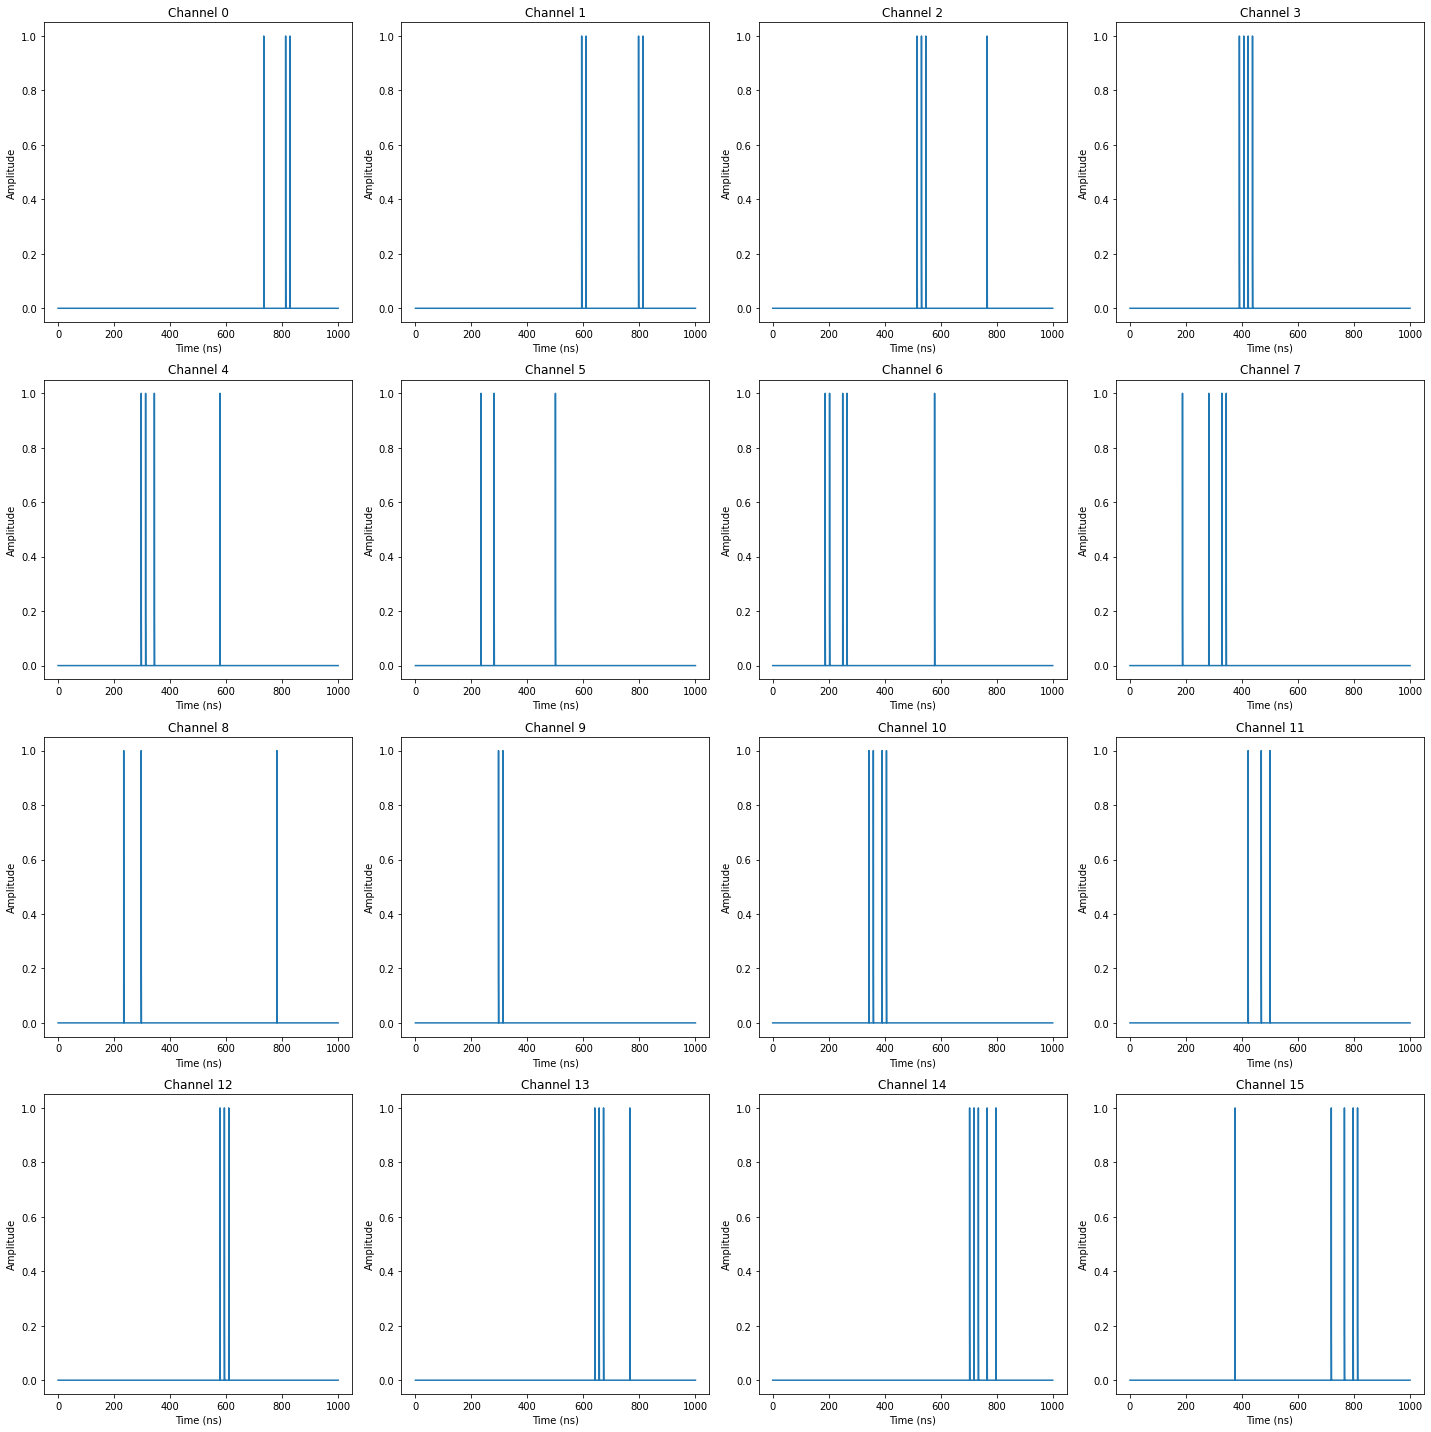

In [8]:
event_index = 1 # Index of the event to plot

pulses = np.load("./dataset/pulses_testSet.npz")['x_test']

fig, axes = plt.subplots(4,4, figsize=(20, 20))  # Create a 4x4 grid of subplots

for i, ax in enumerate(axes.flatten()):
    channel_index = i  # Index of the channel to plot
    signal = pulses[event_index, channel_index, :]  # Get the signal for the specified event and channel
    ax.plot(time, signal)
    ax.set_title(f'Channel {channel_index}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude')


plt.tight_layout()
plt.show()